# Amazon Fine Food Reviews Analysis

## [1]. Reading Data

### [1.1] Loading the data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

# [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# [3] Preprocessing

## [3.1]. Preprocessing Review Text

In [16]:
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [18]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [19]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [23]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:26<00:00, 1014.72it/s]


In [25]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams

In [27]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [28]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


# [5] Applying Naive Bayes

## [5.1] Applying Naive Bayes on BOW

In [29]:
from sklearn.cross_validation import train_test_split
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final_counts,final['Score'].values,test_size=0.3)


#Normalize Data
from sklearn import preprocessing
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Train Data Size:  (61441, 54904)
Test Data Size:  (26332, 54904)


In [30]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(5591, 54904) (5585, 54904)
(11176, 54904) (5585, 54904)
(16761, 54904) (5585, 54904)
(22346, 54904) (5585, 54904)
(27931, 54904) (5585, 54904)
(33516, 54904) (5585, 54904)
(39101, 54904) (5585, 54904)
(44686, 54904) (5585, 54904)
(50271, 54904) (5585, 54904)
(55856, 54904) (5585, 54904)


## [5.1.1] Bernoulli Naive Bayes

In [31]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1,scoring = 'roc_auc')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC Score: %.2f%%"%(gsv.best_score_))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   27.2s finished


Best HyperParameter:  {'alpha': 0.1}
Best AUC Score: 0.90%


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


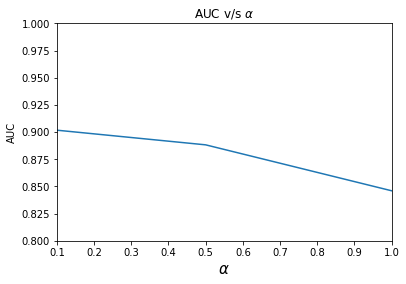

In [38]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(0.1,1.0)
plt.ylim(0.8,1.0)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("AUC")
plt.title(r'AUC v/s $\alpha$')
plt.plot(x,y)
plt.show()

In [34]:
#Cross Validation to find alpha
alpha_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_range

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [41]:
from sklearn.model_selection import cross_val_score
cv_scores = []
for alpha in alpha_range:
    clf = BernoulliNB(alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

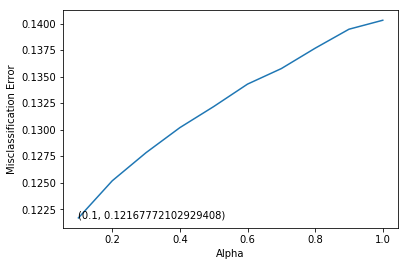

In [42]:
# Calculating missclassification error and plotting alpha vs error plaot to get minimum error.
error = [1 - x for x in cv_scores]
optimal_alpha = alpha_range[error.index(min(error))]
plt.plot(alpha_range, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.show()

##### So the misclassification error obtained is minimum for alpha = 0.1 

Accuracy on test set: 87.870%
Precision on test set: 0.927
Recall on test set: 0.928
F1-Score on test set: 0.928
AUC-Score on test set: 0.777
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



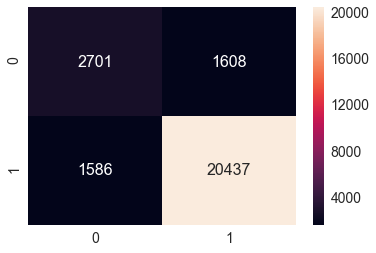

In [44]:
#Testing Accuracy on Test data
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score,roc_auc_score
import seaborn as sns

bnb = BernoulliNB(alpha=0.1)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("AUC-Score on test set: %0.3f"%(roc_auc_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [45]:
results=pd.DataFrame(columns=['Featuraization', 'Algo', 'Hyperparameter', 'Test-acc', 'F1- Score' ])

In [46]:
new = ['BOW','BernoulliNB',0.1,87.870,0.928]
results.loc[0]=new

### [5.1.2] Multinomial Naive Bayes

In [75]:
tqdm
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1,scoring = 'roc_auc')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC_Score: %.2f%%"%(gsv.best_score_))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   13.8s finished


Best HyperParameter:  {'alpha': 0.05}
Best AUC_Score: 0.92%


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


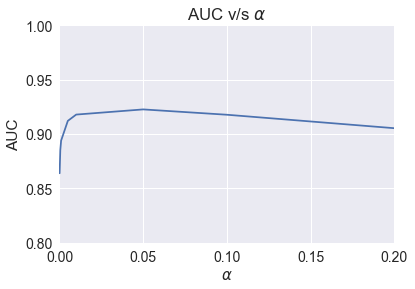

In [73]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(0,0.2)
plt.ylim(0.8,1.0)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("AUC")
plt.title(r'AUC v/s $\alpha$')
plt.plot(x,y)
plt.show()

##### At alpha = 0.05 the AUC_Score is very high

In [68]:
#Cross Validation to find alpha
alpha_range = [ 0.01,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
alpha_range

[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [69]:
from sklearn.model_selection import cross_val_score
cv_scores = []
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

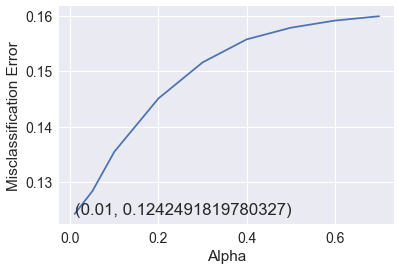

In [70]:
# Calculating missclassification error and plotting alpha vs error plaot to get minimum error.
error = [1 - x for x in cv_scores]
optimal_alpha = alpha_range[error.index(min(error))]
plt.plot(alpha_range, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.show()

##### At alpha = 0.01 the misclassification Error is very low

Accuracy on test set: 87.399%
Precision on test set: 0.873
Recall on test set: 0.995
F1-Score on test set: 0.930
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



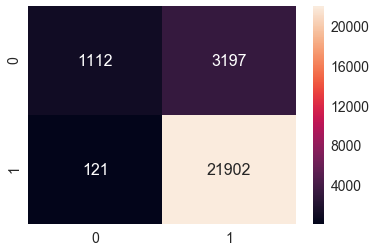

In [71]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [76]:
new = ['BOW','MultinomialNB',0.01,87.399,0.930]
results.loc[1] = new

In [81]:

def show_most_informative_features(vectorizer, bnb, n=15):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(bnb.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,bnb)

			Positive						Negative
________________________________________________________________________________________________
	-13.1533	able find      				-2.0127	thinking would 
	-13.1533	able get       				-2.0525	flavor nice    
	-13.1533	absolute favorite				-2.0650	fake           
	-13.1533	absolutely     				-2.2765	time finding   
	-13.1533	absolutely best				-2.6762	pros           
	-13.1533	absolutely love				-2.6864	walnut         
	-13.1533	absolutely loves				-2.7801	fill           
	-13.1533	absorb         				-2.8594	brother        
	-13.1533	acai           				-3.0682	premium        
	-13.1533	acceptable     				-3.1933	trouble        
	-13.1533	access         				-3.2211	bpa            
	-13.1533	according      				-3.3100	meal           
	-13.1533	acidic         				-3.3111	example        
	-13.1533	acquired       				-3.3116	hidden         
	-13.1533	add            				-3.3506	intolerant     


## Bi-gram

In [82]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final_bigram_counts,final['Score'].values,test_size=0.3)


#Normalize Data
from sklearn import preprocessing
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (61441, 5000)
Test Data Size:  (26332, 5000)


In [83]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1,scoring = 'roc_auc')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC: %.2f%%"%(gsv.best_score_))

Wall time: 0 ns
Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:   20.8s finished


Best HyperParameter:  {'alpha': 0.1}
Best AUC: 0.93%


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


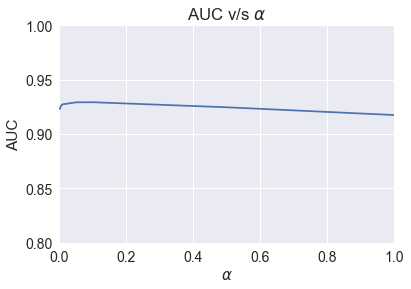

In [85]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(0.0,1.0)
plt.ylim(0.8,1.0)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("AUC")
plt.title(r'AUC v/s $\alpha$')
plt.plot(x,y)
plt.show()

##### At alpha = 0.1 the AUC_Score is very high 

In [87]:
#Cross Validation to find alpha
alpha_range = [0.01,0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_range

[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [90]:
from sklearn.model_selection import cross_val_score
cv_scores = []
for alpha in alpha_range:
    clf = BernoulliNB(alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'roc_auc')
    cv_scores.append(scores.mean())

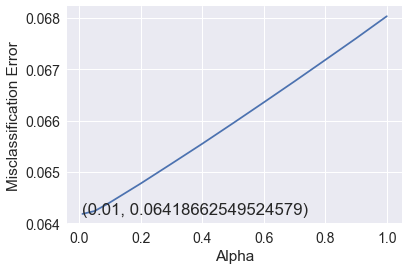

In [91]:
# Calculating missclassification error and plotting alpha vs error plaot to get minimum error.
error = [1 - x for x in cv_scores]
optimal_alpha = alpha_range[error.index(min(error))]
plt.plot(alpha_range, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.show()

###### At alpha = 0.01 the misclassification error is very low 

Accuracy on test set: 89.579%
Precision on test set: 0.947
Recall on test set: 0.927
F1-Score on test set: 0.937
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



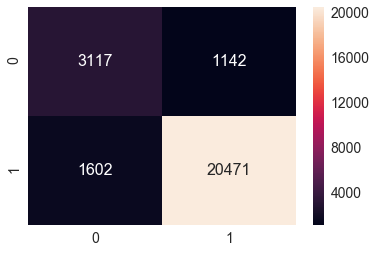

In [94]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(alpha=0.01)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [95]:
new = ['Bi-gram','BernoulliNB',0.01,89.579,0.937]
results.loc[2] = new

### Multinomial Naive Bayes

In [97]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1,scoring = 'roc_auc')
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC_Score: %.2f%%"%(gsv.best_score_))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.3s finished


Best HyperParameter:  {'alpha': 0.1}
Best AUC_Score: 0.94%


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


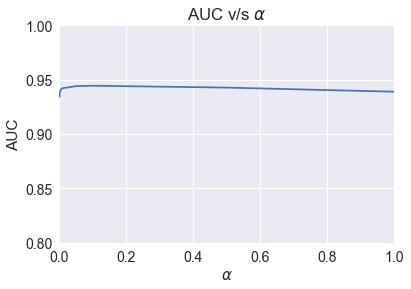

In [99]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(0,1.0)
plt.ylim(0.8,1.0)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("AUC")
plt.title(r'AUC v/s $\alpha$')
plt.plot(x,y)
plt.show()

In [100]:
#Cross Validation to find alpha
alpha_range = [0.01,0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_range

[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [102]:
from sklearn.model_selection import cross_val_score
cv_scores = []
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

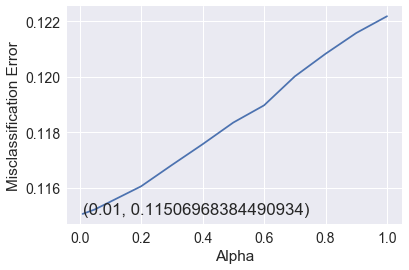

In [103]:
# Calculating missclassification error and plotting alpha vs error plaot to get minimum error.
error = [1 - x for x in cv_scores]
optimal_alpha = alpha_range[error.index(min(error))]
plt.plot(alpha_range, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.show()

###### At alpha = 0.01 the misclassification Error is very low

Accuracy on test set: 88.394%
Precision on test set: 0.882
Recall on test set: 0.995
F1-Score on test set: 0.935
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



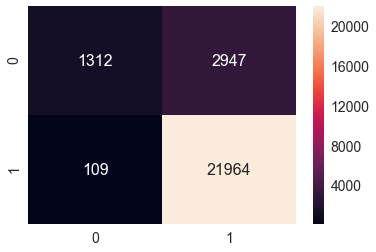

In [106]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [107]:
new = ['Bi-gram','MultinimialNB',0.01,88.394,0.935]
results.loc[3] = new

### Feature Importance[Top- 10]

In [108]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(count_vect,bnb)

			Positive						Negative
________________________________________________________________________________________________
	-7.9588	nespresso      				-0.6820	not            
	-7.9047	bulbs          				-1.2379	like           
	-7.8047	expired        				-1.2693	good           
	-7.5535	inedible       				-1.2990	great          
	-7.5535	trap           				-1.5259	one            
	-7.5171	not impressed  				-1.5686	taste          
	-7.4821	quality control				-1.5937	love           
	-7.4482	disappointed not				-1.6815	flavor         
	-7.4482	give away      				-1.6897	would          
	-7.4154	money not      				-1.7373	product        


## [5.2] Applying Naive Bayes on TFIDF

In [109]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final_tf_idf,final['Score'].values,test_size=0.3)

#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (61441, 51709)
Test Data Size:  (26332, 51709)


### [5.2.1] Bernoulli Naive Bayes

In [110]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1,scoring = 'roc_auc')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC_Score: %.2f%%"%(gsv.best_score_))

Wall time: 0 ns
Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:   31.8s finished


Best HyperParameter:  {'alpha': 0.1}
Best AUC_Score: 0.94%


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


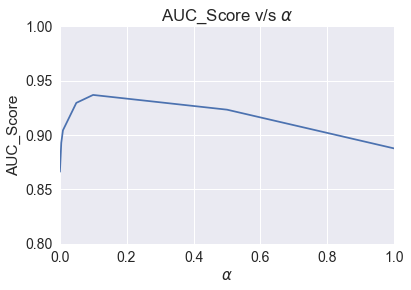

In [111]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(0,1)
plt.ylim(0.8,1.0)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("AUC_Score")
plt.title(r'AUC_Score v/s $\alpha$')
plt.plot(x,y)
plt.show()

In [112]:
#Cross Validation to find alpha
alpha_range = [0.01,0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_range

[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [113]:
from sklearn.model_selection import cross_val_score
cv_scores = []
for alpha in alpha_range:
    clf = BernoulliNB(alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())


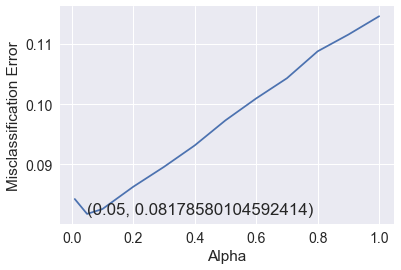

In [114]:
# Calculating missclassification error and plotting alpha vs error plaot to get minimum error.
error = [1 - x for x in cv_scores]
optimal_alpha = alpha_range[error.index(min(error))]
plt.plot(alpha_range, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.show()

###### At alpha = 0.05 the misclassification Error is very low

Accuracy on test set: 92.010%
Precision on test set: 0.945
Recall on test set: 0.961
F1-Score on test set: 0.953
AUC-Score on test set: 0.835
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



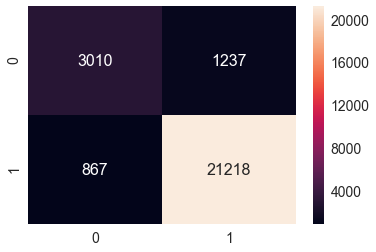

In [118]:
#Testing Accuracy on Test data
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score,roc_auc_score
import seaborn as sns

bnb = BernoulliNB(alpha=0.05)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("AUC-Score on test set: %0.3f"%(roc_auc_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [119]:
new = ['tf-idf','BernouliNB',0.05,92.010,0.953]
results.loc[4] = new

### [5.2.2] Multinomial Naive Bayes

In [120]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1,scoring = 'roc_auc')
gsv.fit(X_train,y_train)

print("Best HyperParameter: ",gsv.best_params_)
print("Best AUC_Score: %.2f%%"%(gsv.best_score_))

Wall time: 0 ns
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   17.7s finished


Best HyperParameter:  {'alpha': 0.1}
Best AUC_Score: 0.94%


C:\Users\BALARAMI REDDY\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


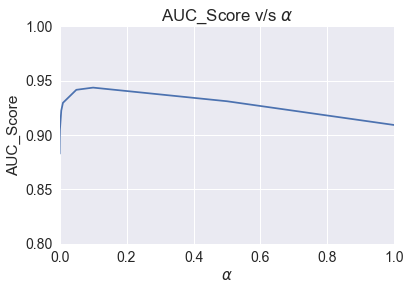

In [122]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(0,1.0)
plt.ylim(0.8,1.0)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("AUC_Score")
plt.title(r'AUC_Score v/s $\alpha$')
plt.plot(x,y)
plt.show()

In [123]:
#Cross Validation to find alpha
alpha_range = [0.01,0.05,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
alpha_range

[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [124]:
from sklearn.model_selection import cross_val_score
cv_scores = []
for alpha in alpha_range:
    clf = MultinomialNB(alpha=alpha)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

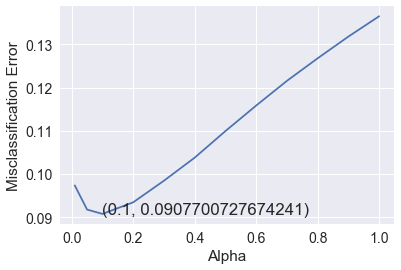

In [125]:
# Calculating missclassification error and plotting alpha vs error plaot to get minimum error.
error = [1 - x for x in cv_scores]
optimal_alpha = alpha_range[error.index(min(error))]
plt.plot(alpha_range, error)
xy = (optimal_alpha, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Alpha")
plt.ylabel("Misclassification Error")
plt.show()


###### At alpha = 0.1 the misclassification Error is very low

Accuracy on test set: 91.182%
Precision on test set: 0.914
Recall on test set: 0.987
F1-Score on test set: 0.949
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



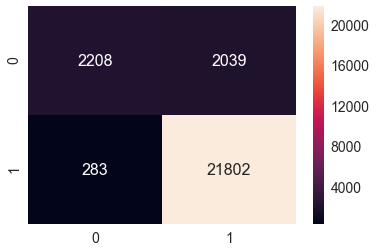

In [126]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.1)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [127]:
new = ['tf-idf','MultinomialNB',0.1,91.182,0.949]
results.loc[5] = new

### [5.5.3] Feature Importance[Top-10]

In [128]:
def show_most_informative_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tf_idf_vect,bnb)

			Positive						Negative
________________________________________________________________________________________________
	-13.8452	accept returns 				-0.6829	not            
	-13.8452	advertising not				-1.2365	like           
	-13.8452	ago product    				-1.2730	good           
	-13.8452	amazon policy  				-1.2933	great          
	-13.8452	avoid costs    				-1.5142	one            
	-13.8452	bad threw      				-1.5697	taste          
	-13.8452	bait switch    				-1.5866	love           
	-13.8452	bland tasteless				-1.6952	would          
	-13.8452	coffee terrible				-1.6961	flavor         
	-13.8452	completely disappointed				-1.7175	product        


### Performance Table

In [129]:
results

,Featuraization,Algo,Hyperparameter,Test-acc,F1- Score
0,BOW,BernoulliNB,0.10,87.870,0.928
1,BOW,MultinomialNB,0.01,87.399,0.930
2,Bi-gram,BernoulliNB,0.01,89.579,0.937
3,Bi-gram,MultinimialNB,0.01,88.394,0.935
4,tf-idf,BernouliNB,0.05,92.010,0.953
5,tf-idf,MultinomialNB,0.10,91.182,0.949


### Conclusion:

1.The best thing about Naive Bayes it much quicker than algorithms amazingly fast training times

2.Best Model is tf-idf with accuracy of 92.010% and f1-score of 0.953

3.BernoulliNB is better then MultinomialNB